In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
plot_out_dir = Path("outputs/plots/plots")
plot_out_dir.mkdir(parents=True, exist_ok=True)

# GMM simulation results

In [3]:
random_seed = 42

In [4]:
# Load results for all n_select values
result_fps = list(Path("outputs/test_sampling_gmm/").glob(f"*{random_seed}.json"))
data_for_plot = []

# Collect data
for result_fp in result_fps:
    with open(result_fp, "r") as f:
        results = json.load(f)
    method = results["strategy"]
    n_select = results["n_select"]

    # Extract values from all repeats
    for repeat in results["repeats"]:
        data_for_plot.append(
            {
                "strategy": method,
                "n_select": n_select,
                "ood_accuracy": repeat["ood_accuracy"],
            }
        )

# Convert to numpy arrays for easier processing
data_array = np.array(
    [[d["strategy"], d["n_select"], d["ood_accuracy"]] for d in data_for_plot]
)
strategies = np.unique(data_array[:, 0])
n_selects = np.sort(
    np.unique(data_array[:, 1].astype(int))
)  # Sort n_selects for proper line plotting

In [5]:
scale = 1.2
plt.rcParams["font.size"] = 12 * scale
plt.rcParams["axes.labelsize"] = 14 * scale
plt.rcParams["axes.titlesize"] = 14 * scale
plt.rcParams["xtick.labelsize"] = 12 * scale
plt.rcParams["ytick.labelsize"] = 12 * scale
plt.rcParams["legend.fontsize"] = 10 * scale

In [6]:
label_mapping = {
    "kcenter": "Core-Set",
    "kmeans": "kMeans",
    "margin": "Margin-based",
    "random": "Random",
    "stratified": "Stratified",
    "greedy_ed": "ED opt. (random)",
    "greedy_ed_kmeans": "ED opt. (kMeans)",
}

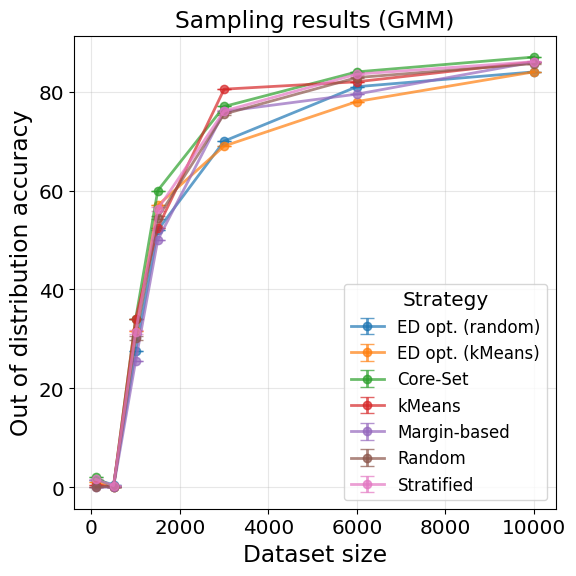

In [7]:
# Create the plot
plt.figure(figsize=(6, 6))

# Get strategies excluding oracle
strategies = [s for s in strategies if s != "oracle"]

# Custom colors and styles
style_mapping = {
    "random": {"color": "gray", "linestyle": "--", "alpha": 1.0},
    "stratified": {"color": "gray", "linestyle": "-", "alpha": 1.0},
}

# All other strategies will use Set2 colors
other_strategies = [s for s in strategies if s not in style_mapping]
other_colors = plt.cm.Set2(np.linspace(0, 1, len(other_strategies)))
for i, strategy in enumerate(other_strategies):
    style_mapping[strategy] = {"color": other_colors[i], "linestyle": "-", "alpha": 1.0}

for strategy in strategies:
    means = []
    sems = []  # standard errors

    for n in n_selects:
        values = data_array[
            (data_array[:, 0] == strategy) & (data_array[:, 1].astype(int) == n), 2
        ].astype(float)
        means.append(np.mean(values))
        sems.append(np.std(values) / np.sqrt(len(values)))

    valid_mask = ~np.isnan(means)
    valid_n_selects = n_selects[valid_mask]
    valid_means = np.array(means)[valid_mask] * 100
    valid_sems = np.array(sems)[valid_mask] * 100

    # Rename kcenter to Core-Set in legend
    label = label_mapping.get(strategy, strategy)

    style = style_mapping[strategy]
    plt.errorbar(
        valid_n_selects,
        valid_means,
        yerr=valid_sems,
        label=label,
        alpha=0.7,
        marker="o",
        markersize=6,
        capsize=5,
        linewidth=2,
    )

plt.xlabel("Dataset size")
plt.ylabel("Out of distribution accuracy")
plt.title("Sampling results (GMM)")
plt.legend(title="Strategy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plot_out_dir / "gmm_ood_accuracy_by_dataset_size_and_strategy.pdf")
plt.show()

# LAION simulation results

In [8]:
# Load all LAION results
result_fps = list(Path("outputs/test_sampling_laion/").glob("*.json"))

# Process results
method_results = {}
for result_fp in result_fps:
    with open(result_fp, "r") as f:
        results = json.load(f)

    method = results["strategy"]
    n_select = results["n_select"]

    if (method, n_select) not in method_results:
        method_results[(method, n_select)] = []

    # For each repeat, normalize the OOD accuracies and compute mean
    if len(results["repeats"]) > 6:
        group_results = []
        for group in range(6):
            group_repeats = results["repeats"][group * 100 : (group + 1) * 100]
            avg_group_accuracy = np.mean(
                [np.mean(repeat["ood_accuracy"]) for repeat in group_repeats]
            )
            group_results.append(avg_group_accuracy)
        method_results[(method, n_select)] = (
            np.mean(group_results),
            np.std(group_results),
        )

    else:
        for group in results["repeats"]:
            avg_group_accuracy = np.mean(group["ood_accuracy"])
            method_results[(method, n_select)].append(avg_group_accuracy)
        method_results[(method, n_select)] = (
            np.mean(method_results[(method, n_select)]),
            np.std(method_results[(method, n_select)]),
        )

In [9]:
laion_ood_df_data = []
for method, n_select in method_results:
    laion_ood_df_data.append(
        {
            "method": method,
            "n_select": n_select,
            "ood_accuracy": method_results[(method, n_select)][0],
            "ood_accuracy_std": method_results[(method, n_select)][1],
        }
    )
laion_ood_df = pd.DataFrame(laion_ood_df_data)

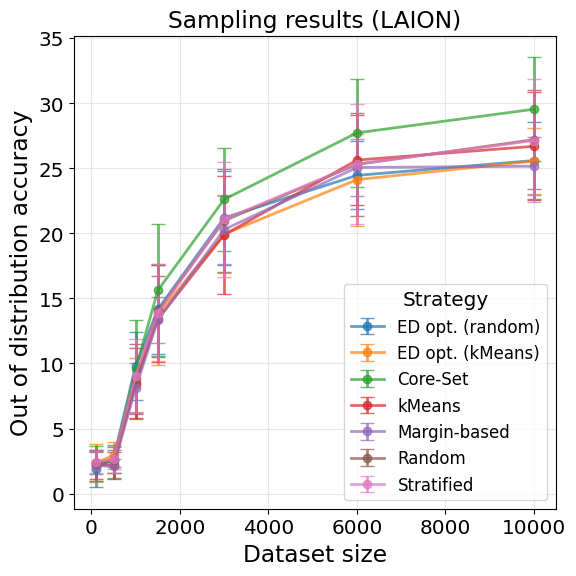

In [10]:
# Create the plot
plt.figure(figsize=(6, 6))

# Get strategies excluding oracle
methods = [m for m in sorted(laion_ood_df["method"].unique()) if m != "oracle"]

# Plot for each method
for method in methods:
    method_data = laion_ood_df[laion_ood_df["method"] == method].sort_values(
        by="n_select"
    )

    # Rename kcenter to Core-Set in legend
    label = label_mapping.get(method, method)

    style = style_mapping[method]
    plt.errorbar(
        method_data["n_select"],
        method_data["ood_accuracy"] * 100,  # Convert to percentage
        yerr=method_data["ood_accuracy_std"] * 100,
        label=label,
        alpha=0.7,
        marker="o",
        markersize=6,
        capsize=5,
        linewidth=2,
    )

plt.xlabel("Dataset size")
plt.ylabel("Out of distribution accuracy")
plt.title("Sampling results (LAION)")
plt.legend(title="Strategy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plot_out_dir / "laion_ood_accuracy_by_dataset_size_and_strategy.pdf")
plt.show()

# NSD sampling results

In [11]:
nsd_sampling_result_dir = Path("outputs/test_nsd_sampling")

In [12]:
# Load all NSD results
nsd_result_fps = list(nsd_sampling_result_dir.glob("*.json"))

# Process results
nsd_method_results = {}
for result_fp in nsd_result_fps:
    subject_id = result_fp.stem.split("_")[2]
    with open(result_fp, "r") as f:
        results = json.load(f)

    method = results["strategy"]
    n_select = results["n_select"]

    if (method, n_select) not in nsd_method_results:
        nsd_method_results[(subject_id, method, n_select)] = []

    # Extract normalized correlations from repeats
    for repeat in results["repeats"]:
        nsd_method_results[(subject_id, method, n_select)].append(repeat["avg_corr"])

In [13]:
plot_data = []
for subject_id, method, n_select in nsd_method_results:
    plot_data.append(
        {
            "subject_id": subject_id,
            "method": method,
            "n_select": n_select,
            "avg_corr": np.mean(nsd_method_results[(subject_id, method, n_select)]),
        }
    )
plot_data_df = pd.DataFrame(plot_data)

In [14]:
# normalize within each subject, then average across subjects and plot
plot_data_df = (
    plot_data_df.groupby("subject_id")
    .apply(lambda x: x.assign(avg_corr=x["avg_corr"] / x["avg_corr"].max()))
    .reset_index(drop=True)
)

/tmp/ipykernel_3230744/2667266637.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_data_df = plot_data_df.groupby('subject_id').apply(lambda x: x.assign(avg_corr=x['avg_corr'] / x['avg_corr'].max())).reset_index(drop=True)


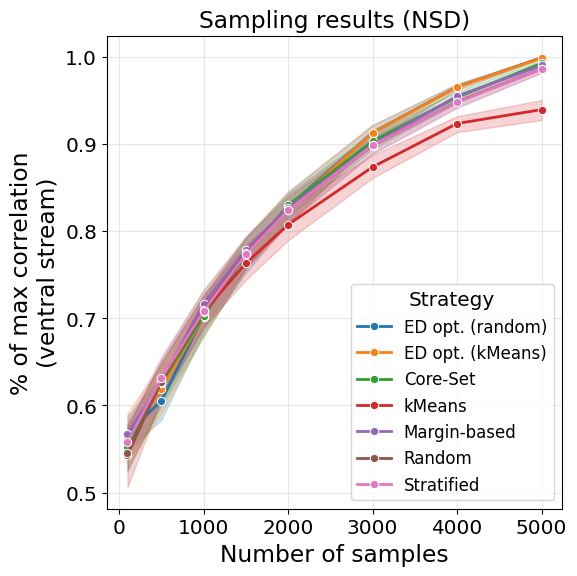

In [17]:
# Remove oracle from the data
plot_data_df = plot_data_df[
    (plot_data_df["method"] != "oracle")
    & ((plot_data_df["method"] != "margin") | (plot_data_df["subject_id"] == "1"))
]

method_order = [
    "greedy_ed",
    "greedy_ed_kmeans",
    "kcenter",
    "kmeans",
    "margin",
    "random",
    "stratified",
]

# Create the plot
plt.figure(figsize=(6, 6))
sns.lineplot(
    data=plot_data_df,
    x="n_select",
    y="avg_corr",
    hue="method",
    marker="o",
    markersize=6,
    hue_order=method_order,
    linewidth=2,
)

# Rename 'kcenter' to 'Core-Set' in legend
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label_mapping.get(label, label) for label in labels]
plt.legend(handles, labels, title="Strategy")

plt.xlabel("Number of samples")
plt.ylabel("% of max correlation\n(ventral stream)")
plt.title("Sampling results (NSD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plot_out_dir / "nsd_sampling_strategies_comparison.pdf")
plt.show()